- http://matthewrocklin.com/blog/work/2017/03/28/dask-xgboost
- https://examples.dask.org/machine-learning/xgboost.html#Learn-more

# setup

In [32]:
import dask.dataframe as dd
import dask.array as da
import pandas as pd
from dask_ml.model_selection import train_test_split
import dask
import xgboost
import dask_xgboost
from dask.distributed import Client
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
# p_out=f'{HOME}/output/{PRFX}'
# Path(p_out).mkdir(exist_ok=True)

cols=[
'text_tokens',
'hashtags',
'tweet_id',
'present_media',
'present_links',
'present_domains',
'tweet_type',
'language',
'timestamp',

'engaged_user_id',
'engaged_follower_count',
'engaged_following_count',
'engaged_is_verified',
'engaged_account_creation_time',

'engaging_user_id',
'engaging_follower_count',
'engaging_following_count',
'engaging_is_verified',
'engaging_account_creation_time',

'engagee_follows_engager',
'reply_engagement_timestamp',
'retweet_engagement_timestamp',
'retweet_with_comment_engagement_timestamp',
'like_engagement_timestamp',
]

cols_cat = [
'tweet_type',
'language',
'engaged_is_verified',
'engaging_is_verified',
'engagee_follows_engager',
]


cols_tgt_tmstmp=['reply_engagement_timestamp',
'retweet_engagement_timestamp',
'retweet_with_comment_engagement_timestamp',
'like_engagement_timestamp',
]
tgts=['Reply','Retweet','RT with comment','Like',]


In [15]:
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# prepare data

In [34]:
!head -5000000 {p_in}/trn.tsv > {p_in}/trn5e6.tsv

In [35]:
df=dd.read_csv(f'{p_in}/trn5e6.tsv',
               sep='\x01',
               header=None,
               names=cols,)

In [36]:
ys=~df[cols_tgt_tmstmp].isna().to_dask_array(lengths=True)

Xcat=dd.get_dummies(df[cols_cat].categorize()).to_dask_array(lengths=True)

df['has_media']=~df.present_media.isna()

X=df[['engaged_follower_count',
      'engaging_following_count',
      'engaged_is_verified', 
      'engagee_follows_engager',
      'engaged_account_creation_time',
      'has_media',]].to_dask_array(lengths=True)


In [37]:
X=da.concatenate([Xcat,X],axis=1)
X=X.rechunk({1: X.shape[1]})

In [38]:
Xtrn, Xval, ystrn, ysval = train_test_split(X, ys, test_size=0.15)

# train

In [39]:
client = Client(n_workers=4, threads_per_worker=1)

/home/ubuntu/anaconda3/envs/dask-tutorial/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [40]:
params = {'objective': 'binary:logistic', 'verbosity':2}

tgt2bst={}
for i,tgt in enumerate(tgts):
    print(dtnow(), tgt)
    tgt2bst[tgt] = dask_xgboost.train(client, params, Xtrn, ystrn[:,i], num_boost_round=20)

2020-03-15 03:14:41 Reply
2020-03-15 03:23:55 Retweet
2020-03-15 03:32:53 RT with comment
2020-03-15 03:43:17 Like


Reply


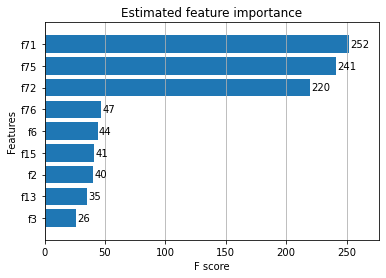

Retweet


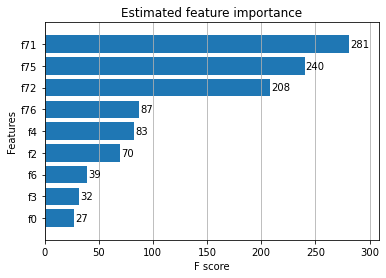

RT with comment


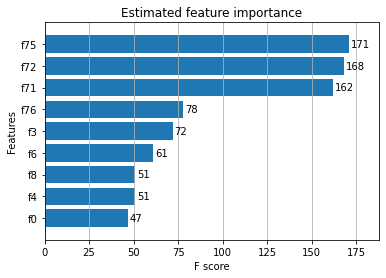

Like


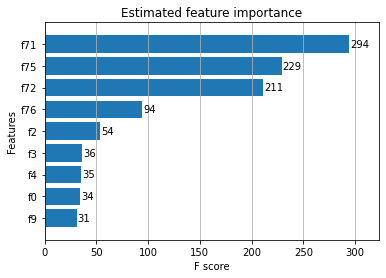

In [41]:
def show_feat_importance(bst):
    ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()

for i,tgt in enumerate(tgts):
    print(tgt)
    show_feat_importance(tgt2bst[tgt])

## validate

In [42]:
tgt2yval={}
tgt2prdval={}
for i,tgt in enumerate(tgts):
    prdval = dask_xgboost.predict(client, tgt2bst[tgt], Xval).persist()
    yval, prdval = dask.compute(ysval[:,i], prdval)
    tgt2yval[tgt]=yval
    tgt2prdval[tgt]=prdval

In [43]:
def show_roc(prd,y):
    fpr, tpr, _ = roc_curve(y,prd)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, lw=3,
            label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title="ROC Curve",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()

Reply
auc: 0.08947245779397475
rce: 9.442492081855525


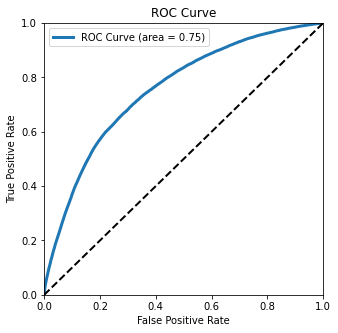

Retweet
auc: 0.273306375758952
rce: 8.461442098225225


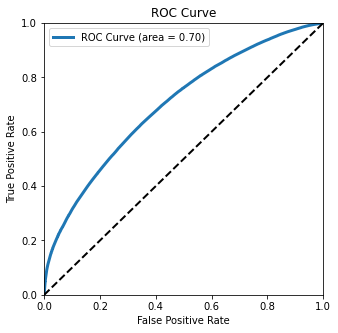

RT with comment
auc: 0.015267854981639253
rce: 2.643152691556594


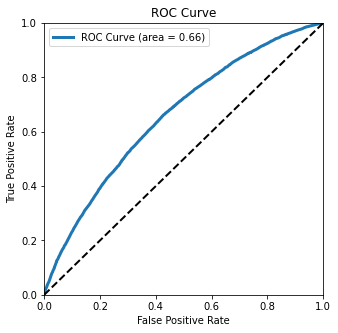

Like
auc: 0.628001630967579
rce: 8.269281443734599


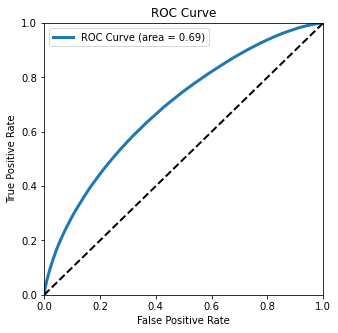

In [44]:
tgt2auc={}
tgt2rce={}
for i,tgt in enumerate(tgts):
    print(tgt)
    yval = tgt2yval[tgt]
    prdval = tgt2prdval[tgt]
    scr_auc=compute_prauc(prdval, yval)
    scr_rce=compute_rce(prdval, yval)
    tgt2auc[tgt]=scr_auc
    tgt2rce[tgt]=scr_rce
    print('auc:',scr_auc)
    print('rce:', scr_rce)
    show_roc(prdval, yval)

In [45]:
lst=[]
for tgt in ['Retweet','Reply','Like','RT with comment',]:
    lst+=[(f'PRAUC {tgt}',tgt2auc[tgt]),
          (f'RCE {tgt}',tgt2rce[tgt])]

In [46]:
pd.DataFrame(lst).T

,0,1,2,3,4,5,6,7
0,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RT with comment,RCE RT with comment
1,0.273306,8.46144,0.0894725,9.44249,0.628002,8.26928,0.0152679,2.64315
